# MNIST + MLP + CNN

In this notebook, we design and train a Convolutional Neural Network (CNN) for hand-written digit classification task. We use MNIST dataset that contains 28x28 pixel images of a hand-written digit (0 to 9, so 10 classification targets). 

## Goals
1. Design CNN and train on MNIST

Let's start with usual import!

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Create MNIST Dataset
Following the previous notebook, let's create train and test dataset and dataloader

In [2]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Use prepared data handler from pytorch (torchvision)
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=4)

# Use prepared data handler from pytorch (torchvision)
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=4)

## Logistic regression with CNN

we design CNN to try the same task. Let's define 3 convolution layers followed by LeakyReLU for activation and MaxPool2d for downsampling.

In [3]:
class CNN(torch.nn.Module):
    def __init__(self,num_filters=16):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,num_filters,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters,num_filters*2,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters*2,num_filters*4,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(7,7))
        # classifier MLP
        self._classifier = torch.nn.Linear(num_filters*4,10)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

Let's import functions we used in the MLP-MNIST notebook here

In [4]:
from mnist_cnn_utils import run_test, train_torch, moving_average

### Exercise 1

Now let's train this CNN model!

1. Train CNN for 4000 iterations with `Adam` optimizer on CPU, measure the time taken in wall-clock, plot the loss.
2. Do the same but using GPU.


CPU: 70.68499517440796 [s]
GPU: 15.995094537734985 [s]
last 20 average 0.04688924923539162


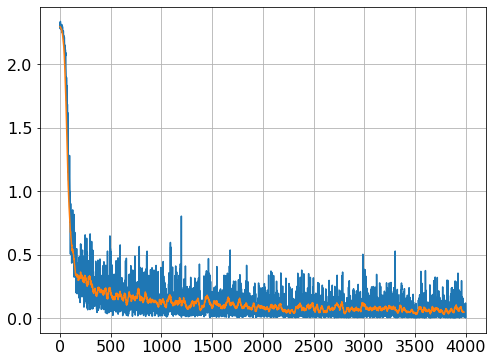

In [5]:
import time

tstart = time.time()
model_c = CNN()
loss = train_torch(train_loader, model_c, 4000, optimizer='Adam', gpu=False)
print('CPU:',time.time() - tstart,'[s]')

tstart = time.time()
model_c = CNN().cuda()
loss = train_torch(train_loader, model_c, 4000, optimizer='Adam', gpu=True)
print('GPU:',time.time() - tstart,'[s]')

plt.plot(loss)
plt.plot(moving_average(loss,20))
print('last 20 average',np.mean(loss[-20:]))

You should see that, this time, GPU gave a good speed-up. This is because CNN takes many separate multiplications of weights with input local matrix, and that can benefit from parallelization = GPU is suited.

### Exercise 2

Run the inference on the test dataset. Compute the accuracy over the all images in the test dataset.

In [6]:
prediction, label, softmax = run_test(model_c,test_loader,gpu=True)

print('model_c',(prediction == label).sum() / len(label))

model_c 0.9817


### Exercise 3
How many parameters are there in our CNN model?

In [7]:
conv_0 = 1*3*3*16 + 16
conv_1 = 16*3*3*32 + 32
conv_2 = 32*3*3*64 + 64
linear = 64*10 + 10
print(conv_0+conv_1+conv_2+linear)

23946
